# Neural Prophet Forecasting model

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from snowflake.snowpark import Session

import warnings

# Ignore only DeprecationWarnings
warnings.filterwarnings('ignore')

from neuralprophet import NeuralProphet

from utils import create_session, mape
import utils

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Data Setup

In [2]:
# session = create_session()

# df = session.table("company_revenue_time_series_1") #with cutoff
# df = df.to_pandas()

# df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
# df = df[['ds', 'y']] # drop everything but these two if there are any

# df['ds'] = pd.to_datetime(df['ds'])
# df = df.sort_values(by='ds')
# df = df.reset_index(drop=True)

# print(df.head())
# print(df.info())
df = utils.get_time_series_1()

df = utils.z_score_outlier(df, 2)

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      364 non-null    datetime64[ns]
 1   y       364 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None
Dropping 12 rows.


## Simple Neural Prophet

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (18) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.
Finding best initial lr: 100%|██████████| 214/214 [00:03<00:00, 70.76it/s]


Training: |          | 0/? [00:34<?, ?it/s, v_num=41, train_loss=0.0179, reg_loss=0.000, MAE=7.35e+3, RMSE=1.07e+4, Loss=0.0177, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


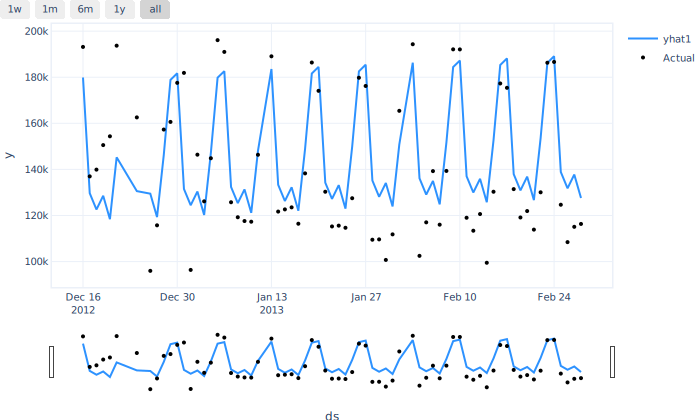

In [4]:
params = {"weekly_seasonality":True}

m = NeuralProphet(**params)

m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')
forecast = m.predict(test)

m.plot(forecast)

In [5]:
nn_prophet_mape = mape(test['y'], forecast['yhat1'])
print(f'Neural Prophet MAPE: {nn_prophet_mape}%')

Neural Prophet MAPE: 10.96%


## Cross Validation

In [6]:
# setup

def cross_validation(params, df):
    folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)
    tests = []
    forecasts = []

    for df_train, df_test in folds:
        m = NeuralProphet(**params)
        m.set_plotting_backend("plotly-static")
        train = m.fit(df=df_train, freq="D")
        forecast = m.predict(df_test)
        test = m.test(df=df_test)
        tests.append(test)
        forecasts.append(forecast)

    return tests, forecasts#, metrics_train, metrics_test


In [7]:
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}
cv_metrics, cv_forecast = cross_validation(params, df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.592% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set ep

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:23<?, ?it/s, v_num=42, train_loss=0.0185, reg_loss=0.000, MAE=6.79e+3, RMSE=1.06e+4, Loss=0.0184, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.42it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.87% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.019802151247859
         MAE_val              6758.4990234375
        RMSE_val              9230.0498046875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:29<?, ?it/s, v_num=43, train_loss=0.0162, reg_loss=0.000, MAE=6.86e+3, RMSE=1.01e+4, Loss=0.0176, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.33it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.02567041851580143
         MAE_val              7768.3212890625
        RMSE_val              10387.107421875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.057% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


Epoch 200: 100%|██████████| 200/200 [00:00<00:00, 527.55it/s]   

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190



Training: |          | 0/? [00:29<?, ?it/s, v_num=44, train_loss=0.0168, reg_loss=0.000, MAE=7.09e+3, RMSE=1.04e+4, Loss=0.0183, RegLoss=0.000]


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.47it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.29it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.19% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 180



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.044488780200481415
         MAE_val              9470.271484375
        RMSE_val              14542.48828125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: |          | 0/? [00:32<?, ?it/s, v_num=45, train_loss=0.0141, reg_loss=0.000, MAE=6.3e+3, RMSE=9.48e+3, Loss=0.0148, RegLoss=0.000] 

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.24it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.05it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06979288160800934
         MAE_val              12444.87109375
        RMSE_val               19248.7421875
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: |          | 0/? [00:34<?, ?it/s, v_num=46, train_loss=0.0168, reg_loss=0.000, MAE=6.9e+3, RMSE=1.05e+4, Loss=0.0166, RegLoss=0.000] 


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.08it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.058269936591386795
         MAE_val             13535.8955078125
        RMSE_val              17793.955078125
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [8]:
combined_forecast = pd.concat(cv_forecast)
print(combined_forecast)
print(f"MAPE: {mape(combined_forecast['y'], combined_forecast['yhat1'])}%")

           ds          y          yhat1          trend  season_weekly
0  2012-07-24  110804.26  110168.851562  127126.726562  -16957.873047
1  2012-07-25  107367.45  114952.398438  127162.242188  -12209.844727
2  2012-07-26  103476.04  106763.515625  127197.757812  -20434.246094
3  2012-07-27  128746.39  129634.703125  127233.273438    2401.429688
4  2012-07-28  151364.59  157756.937500  127268.789062   30488.146484
..        ...        ...            ...            ...            ...
65 2013-02-24  186628.58  205999.437500  152103.093750   53896.324219
66 2013-02-25  124662.95  133152.312500  152235.015625  -19082.712891
67 2013-02-26  108440.70  122779.046875  152366.937500  -29587.884766
68 2013-02-27  115084.81  131298.437500  152498.843750  -21200.419922
69 2013-02-28  116328.96  116238.859375  152630.765625  -36391.906250

[350 rows x 5 columns]
MAPE: 7.17%


## Trying other parameters

Add a parameter for day of month. 

### Data Setup

In [9]:
session = create_session()

df = session.table("company_revenue_time_series_1") #with cutoff
df = df.to_pandas()

df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y', 'day_of_month']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

print(df.head())
print(df.info())

# z-score = 2
mean = df['y'].mean()
std = df['y'].std()

z_scores = (df['y'] - mean) / std

threshold = 2
outlier_index = np.where(np.abs(z_scores) > threshold)[0]
print("Dropping "+str(len(outlier_index)) + " rows.")
df.drop(index=outlier_index,inplace=True)

cutoff = round(len(df)*0.8)
train = df[:cutoff]
test = df[cutoff:]

Epoch 180: 100%|██████████| 180/180 [00:36<00:00,  4.89it/s]    


KeyError: "['day_of_month'] not in index"

### Model fitting and forecast

In [1]:
params = {"weekly_seasonality":True}

m = NeuralProphet(**params)
m.add_future_regressor('day_of_month')
m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train, freq='D')

forecast = m.predict(test)

m.plot(forecast)
print(f"MAPE: {mape(forecast['y'], forecast['yhat1'])}%")

NameError: name 'NeuralProphet' is not defined

In [10]:
# import the .csv file needed. Save it:)